# Numpy

**The** python library for numerical computing is numpy. The main data object is the n-dimensional array; numpy functions create and manipulate n-d arrays. 

In [1]:
import numpy as np


# create a 6x6 array filled with zeros
shape = (6, 6)
array = np.zeros(shape)
print array
print type(array)
print

# the most important attributes of a numpy array are its shape and its dtype
print array.shape
print array.dtype


[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
<type 'numpy.ndarray'>

(6, 6)
float64


In [2]:
# 2d numpy arrays are indexed as [row, column]
array[1, 3] = 1
print array
print

# you can use fancy index slicing on numpy arrays. See http://docs.scipy.org/doc/numpy-1.10.1/user/basics.indexing.html
array[1::2, :] = 2
array[::2, -1] = 3
print array

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  3.]
 [ 2.  2.  2.  2.  2.  2.]
 [ 0.  0.  0.  0.  0.  3.]
 [ 2.  2.  2.  2.  2.  2.]
 [ 0.  0.  0.  0.  0.  3.]
 [ 2.  2.  2.  2.  2.  2.]]


In [3]:
# to create a mask, use comparisons directly on the array
# this creates an array of boolean values
mask = array==3
print mask
print

# a mask array can be used to index arrays (including images)
array[mask] += 1
print array
print 

[[False False False False False  True]
 [False False False False False False]
 [False False False False False  True]
 [False False False False False False]
 [False False False False False  True]
 [False False False False False False]]

[[ 0.  0.  0.  0.  0.  4.]
 [ 2.  2.  2.  2.  2.  2.]
 [ 0.  0.  0.  0.  0.  4.]
 [ 2.  2.  2.  2.  2.  2.]
 [ 0.  0.  0.  0.  0.  4.]
 [ 2.  2.  2.  2.  2.  2.]]



Note that it is almost never necessary to access array elements individually -- use library functions, algebraic expressions, and masks to manipulate images whenever possible.

In [4]:
# numpy has a ton of functions that are useful for manipulating and querying arrays
print np.fliplr(array)
print
print np.mean(array)
print np.std(array)

[[ 4.  0.  0.  0.  0.  0.]
 [ 2.  2.  2.  2.  2.  2.]
 [ 4.  0.  0.  0.  0.  0.]
 [ 2.  2.  2.  2.  2.  2.]
 [ 4.  0.  0.  0.  0.  0.]
 [ 2.  2.  2.  2.  2.  2.]]

1.33333333333
1.24721912892


# Matplotlib

<type 'numpy.ndarray'> (512, 512, 3) float32



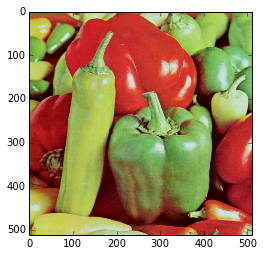

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# imread loads many different image formats as numpy arrays
im = plt.imread('sample-images/peppers.png')
print type(im), im.shape, im.dtype
print 

plt.imshow(im);

The last dimension (of length 3) represents the channels in (red, green, blue) format. Grayscale images may only have 2 dimensions -- there is no channel dimension. Some image formats have an extra alpha channel, which specifies the transparency of each pixel.

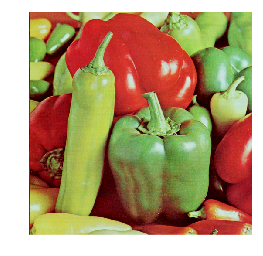

In [6]:
def my_imshow(im, title=None):
    plt.figure()
    plt.imshow(im, cmap='gray', interpolation='none')
    if title:
        plt.title(title)
    plt.axis('off')

    
from matplotlib.colors import ListedColormap

def imshow_overlay(im, mask, alpha=0.5, color='red', **kwargs):
    """Show semi-transparent red mask over an image"""
    mask = mask > 0
    mask = np.ma.masked_where(~mask, mask)        
    plt.imshow(im, **kwargs)
    plt.imshow(mask, alpha=alpha, cmap=ListedColormap([color]))


my_imshow(im)

We can manipulate image pixels in the same way as any numpy array.

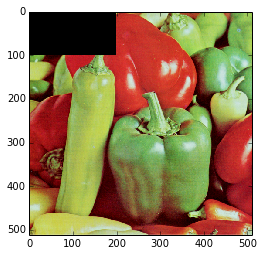

In [7]:
im[:100, :200, :] = 0
my_imshow(im)
plt.axis('on');

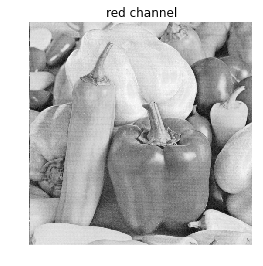

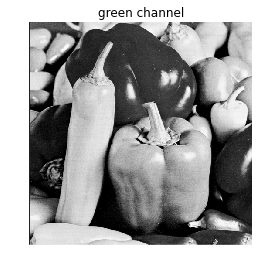

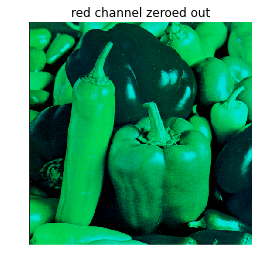

In [8]:
im = plt.imread('sample-images/peppers.png')
red = im[..., 0]
green = im[..., 1]

my_imshow(red, 'red channel')
plt.show()

my_imshow(green, 'green channel')

im[:,:,0] = 0
my_imshow(im, 'red channel zeroed out')


# Filtering: Blurring

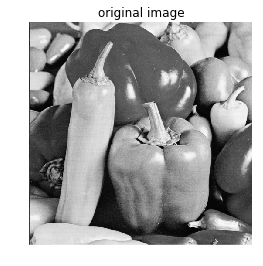

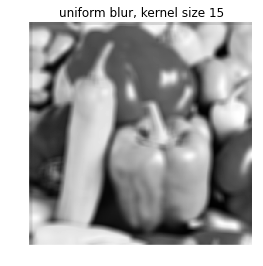

In [9]:
from skimage import filters
from scipy.ndimage.filters import convolve
from skimage import color

im = plt.imread('sample-images/peppers.png')
gray_im = color.rgb2gray(im)


# uniform blur
kern_sz = 15
kernel = np.ones((kern_sz,kern_sz))/kern_sz**2
uniform_blurred = convolve(gray_im, kernel)

my_imshow(gray_im, 'original image')
my_imshow(uniform_blurred, 'uniform blur, kernel size %i' % kern_sz)

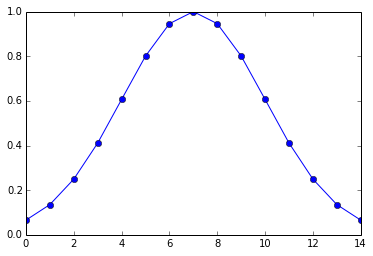

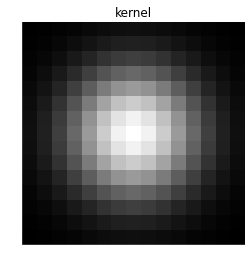

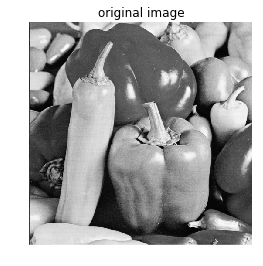

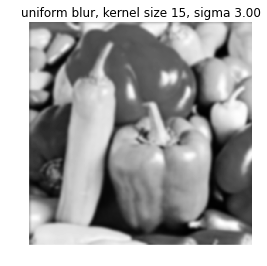

In [10]:
from scipy.signal import gaussian

# gaussian blur
kern_sz = 15
sigma = 3
kernel_1d = gaussian(kern_sz, sigma)
kernel = np.outer(kernel_1d, kernel_1d)
gauss_blurred = convolve(gray_im, kernel)

plt.plot(kernel_1d, 'o-')
my_imshow(kernel, 'kernel')
my_imshow(gray_im, 'original image')
my_imshow(gauss_blurred, 'uniform blur, kernel size %i, sigma %.2f' % (kern_sz, sigma))

**Note:** Both the uniform blur and the gaussian blur have efficient library implementations. In the above examples, I used explicit convolution calls to illustrate how these library functions work "under the hood". In production, you should use the library functions [`uniform filter`](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.filters.uniform_filter.html) and [`gaussian_filter`](http://scikit-image.org/docs/dev/api/skimage.filters.html#gaussian-filter) to do blurring.

# Filtering: Gradients

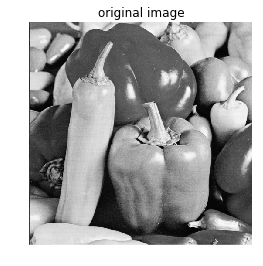

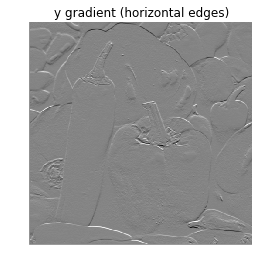

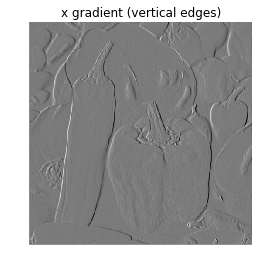

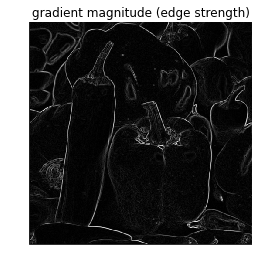

In [11]:
from skimage import filters

grad_x = filters.sobel_h(gray_im)
grad_y = filters.sobel_v(gray_im)
grad_mag = np.sqrt(grad_x**2 + grad_y**2)

my_imshow(gray_im, 'original image')
my_imshow(grad_x, 'y gradient (horizontal edges)')
my_imshow(grad_y, 'x gradient (vertical edges)')
my_imshow(grad_mag, 'gradient magnitude (edge strength)')

# Filtering: Blob Detection

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


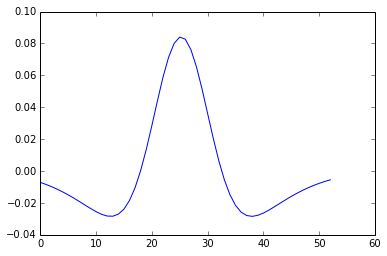

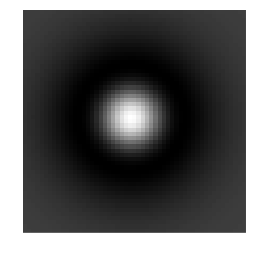

In [12]:
# difference of gaussians

sigma1 = 7.
sigma2 = 2.5*sigma1
kern_sz = 3*sigma2

x, y = np.mgrid[-kern_sz/2+1:kern_sz/2+1, -kern_sz/2+1:kern_sz/2+1]
rsqr = x**2 + y**2
gaussian1 = np.exp(-rsqr/sigma1**2)/sigma1
gaussian2 = np.exp(-rsqr/sigma2**2)/sigma2
dog_kern = gaussian1 - gaussian2

plt.figure()
plt.plot(dog_kern[:, kern_sz/2])

my_imshow(dog_kern)

(-0.5, 440.5, 303.5, -0.5)

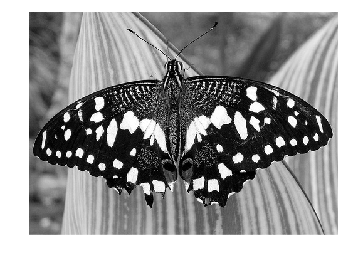

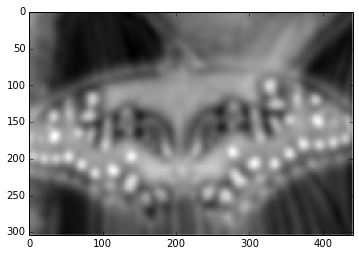

In [30]:
from scipy.signal import fftconvolve  # fftconvolve is usually much faster than plain convolve (they do the same thing)

im = plt.imread('sample-images/butterfly.png')
gray_im = color.rgb2gray(im)

blob_im = fftconvolve(gray_im, dog_kern, mode='valid')

my_imshow(gray_im)
my_imshow(blob_im)


# Thresholding

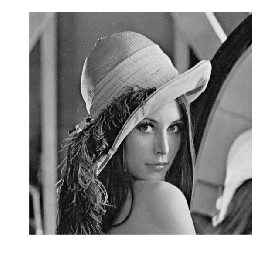

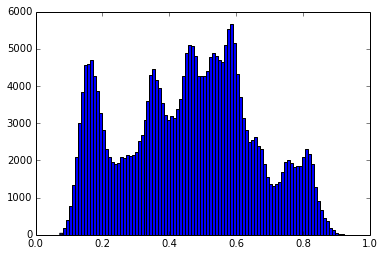

In [14]:
im = plt.imread('sample-images/lena.png')
gray_im = color.rgb2gray(im)

my_imshow(gray_im)

plt.figure()
plt.hist(gray_im.ravel(), bins=100);

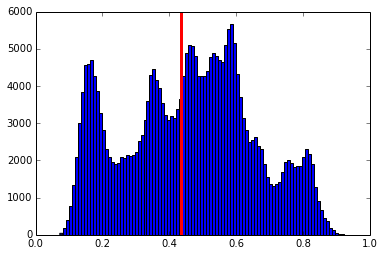

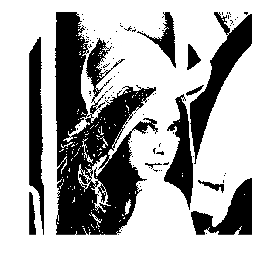

In [15]:
# use otsu's algorithm to select threshold
thresh = filters.threshold_otsu(gray_im)
thresholded = gray_im > thresh

plt.figure()
plt.hist(gray_im.ravel(), bins=100);
plt.plot([thresh, thresh], [0, 6000], linewidth=3, color='r');

my_imshow(thresholded)

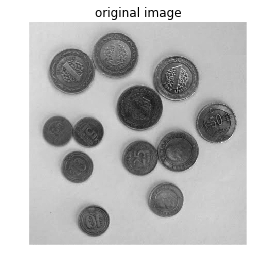

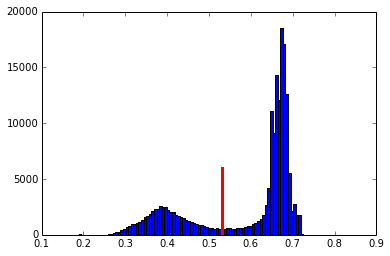

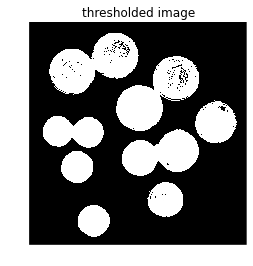

In [16]:
### dark on bright background
im = plt.imread('sample-images/coins.png')
gray_im = color.rgb2gray(im)
thresh = filters.threshold_otsu(gray_im)
coins = gray_im < thresh  # this is now a less-than operator

my_imshow(gray_im, 'original image')

plt.figure()
plt.hist(gray_im.ravel(), bins=100);
plt.plot([thresh, thresh], [0, 6000], linewidth=3, color='r');

my_imshow(coins, 'thresholded image')

# Morphology

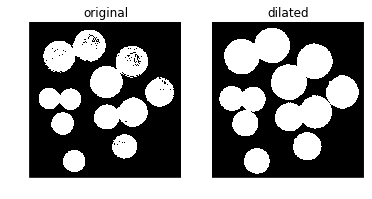

In [17]:
from skimage import morphology
from skimage.morphology import disk


dilated = morphology.binary_dilation(coins, disk(5))


# dilation
plt.figure()
plt.subplot(121)
plt.imshow(coins, cmap='gray', interpolation='none')
plt.title('original')
plt.axis('off');
plt.subplot(122)
plt.imshow(dilated, cmap='gray', interpolation='none')
plt.title('dilated')
plt.axis('off');

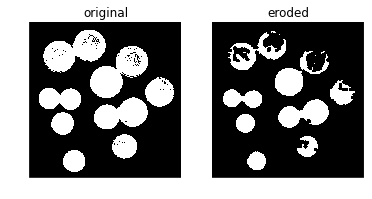

In [18]:
eroded = morphology.binary_erosion(coins, disk(5))

# erosion
plt.figure()
plt.subplot(121)
plt.imshow(coins, cmap='gray', interpolation='none')
plt.title('original')
plt.axis('off');
plt.subplot(122)
plt.imshow(eroded, cmap='gray', interpolation='none')
plt.title('eroded')
plt.axis('off');

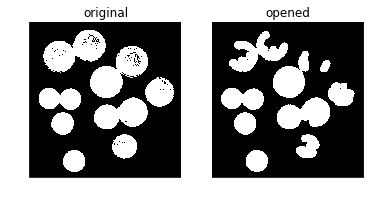

In [19]:
opened = morphology.binary_opening(coins, disk(10))

# opening
plt.figure()
plt.subplot(121)
plt.imshow(coins, cmap='gray', interpolation='none')
plt.title('original')
plt.axis('off');
plt.subplot(122)
plt.imshow(opened, cmap='gray', interpolation='none')
plt.title('opened')
plt.axis('off');

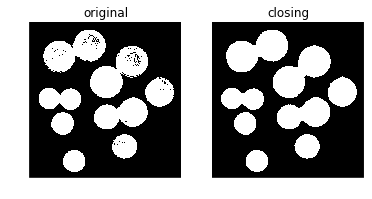

In [20]:
closed = morphology.binary_closing(coins, disk(5))

# closing
plt.figure()
plt.subplot(121)
plt.imshow(coins, cmap='gray', interpolation='none')
plt.title('original')
plt.axis('off');
plt.subplot(122)
plt.imshow(closed, cmap='gray', interpolation='none')
plt.title('closing')
plt.axis('off');


number of coins: 12


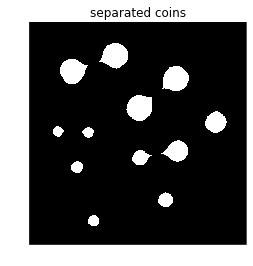

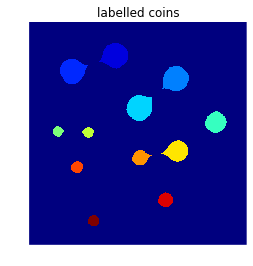

In [21]:
from skimage import measure

separated_coins = morphology.binary_erosion(closed, disk(20))
plt.figure()
plt.imshow(separated_coins, cmap='gray', interpolation='none')
plt.title('separated coins')
plt.axis('off')

labelled_coins = measure.label(separated_coins)
plt.figure()
plt.imshow(labelled_coins, cmap='jet', interpolation='none')
plt.title('labelled coins')
plt.axis('off')

num_coins = len(np.unique(labelled_coins))-1  # subtract 1 b/c background is labelled 0
print 'number of coins: %i' % num_coins

# Worked Example: Segmentation

As an example of a typical image processing problem, we will segment the following image of bacteria. 

original image shape: (1024, 1024, 4)
alpha channel intensity: 1.00 +- 0.00


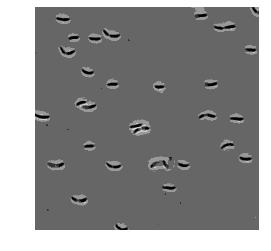

In [22]:
im = plt.imread('sample-images/caulobacter.png')
print 'original image shape:', im.shape
print 'alpha channel intensity: %.2f +- %.2f' % (np.mean(im[:,:,-1]), np.std(im[:,:,-1]))

plt.imshow(im, origin='lower', cmap='gray');
plt.axis('off');

First, convert from color (4 channel, actually) to grayscale.

grayscale image shape: (1024, 1024)


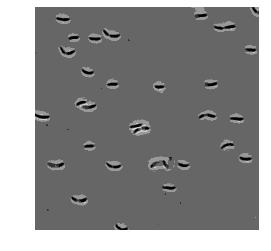

In [23]:
from skimage import color

# convert to gray 
gray_im = color.rgb2gray(im)
print 'grayscale image shape:', gray_im.shape

plt.imshow(gray_im, origin='lower', cmap='gray')
plt.axis('off');

Blur slightly to reduce noise. (This isn't strictly necessary in this case, since it's a fairly high-quality image.)

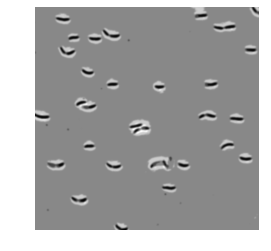

In [24]:
from skimage import filters

blurred_im = filters.gaussian_filter(gray_im, sigma=3)
plt.imshow(blurred_im, origin='lower', cmap='gray')
plt.axis('off');

After the image is suitable pre-processed, we can threshold it to convert it to a cell mask.

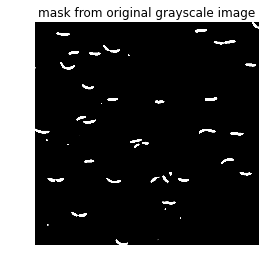

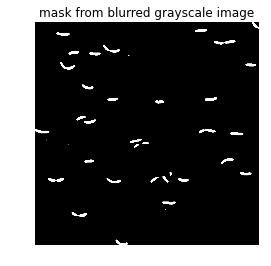

In [25]:
thresh = 0.3
mask = gray_im < thresh

plt.figure()
plt.imshow(mask, origin='lower', cmap='gray');
plt.title('mask from original grayscale image')
plt.axis('off');


thresh = 0.3
blurred_mask = blurred_im < thresh

plt.figure()
plt.imshow(blurred_mask, origin='lower', cmap='gray');
plt.title('mask from blurred grayscale image')
plt.axis('off');


Binary images are manipulated with *morphological operations*. Morphological operations allow us to expand the white regions, shrink the white regions, fill in holes, and more. In this case, we simply want to remove the tiny dots.

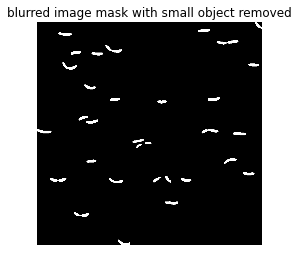

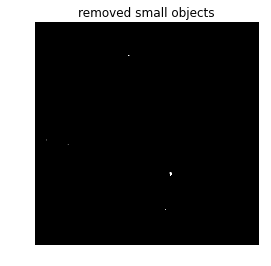

In [26]:
from skimage import morphology

blurred_mask_clean = morphology.remove_small_objects(blurred_mask, min_size=150)

plt.imshow(blurred_mask_clean, origin='lower', cmap='gray');
plt.title('blurred image mask with small object removed')
plt.axis('off');

plt.figure()
plt.imshow(blurred_mask - blurred_mask_clean, origin='lower', cmap='gray');
plt.title('removed small objects')
plt.axis('off');

Some of the cells are touching, so they appear as one object, but we would like to identify them as separate objects. This is a very common problem in segmentation problems (noteably cell tracking). A common approach is to perform a *distance* transform, followed by a *watershed segmentation*.

The distance transform converts a binary mask (black-and-white image) into a floating point image (grayscale image) of the same size. Each pixel in the distance transform represents the *distance of that pixel from the nearest black point in the mask*. Thus, the brighest points in the distance transform are the points that are furthest from object boundaries. An example will help clarify. 

distance transform: (1024, 1024) float64


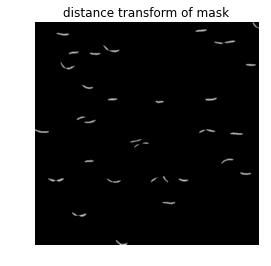

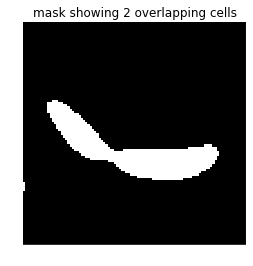

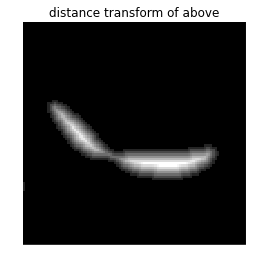

In [27]:
from scipy import ndimage as ndi

distance_im = ndi.distance_transform_edt(blurred_mask_clean)
print 'distance transform:', distance_im.shape, distance_im.dtype

plt.imshow(distance_im, origin='lower', cmap='gray')
plt.title('distance transform of mask')
plt.axis('off');

plt.figure()
plt.imshow(blurred_mask_clean[850:950, 300:400], origin='lower', cmap='gray', interpolation='none')
plt.title('mask showing 2 overlapping cells')
plt.axis('off');

plt.figure()
plt.imshow(distance_im[850:950, 300:400], origin='lower', cmap='gray', interpolation='none')
plt.title('distance transform of above')
plt.axis('off');


If we've done everything right, the peaks of the distance transform image represent the centers of each cell (including those that overlap). We label each separate peak with a unique integer with `skimage.measure.label`.

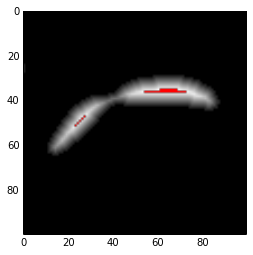

In [28]:
from skimage import feature, measure

peaks_im = feature.peak_local_max(distance_im, indices=False)

plt.figure()
imshow_overlay(distance_im[850:950, 300:400], peaks_im[850:950, 300:400], alpha=1, cmap='gray')

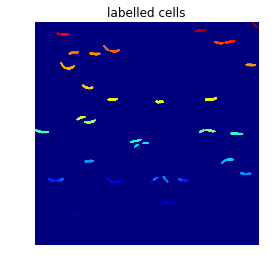

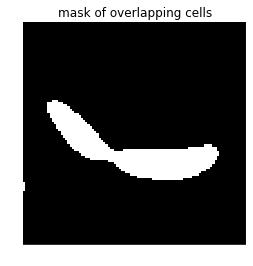

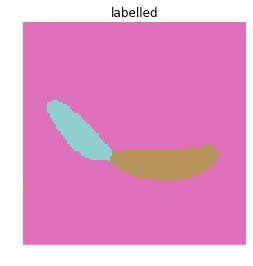

In [29]:
markers_im = measure.label(peaks_im)
labelled_cell_im = morphology.watershed(-distance_im, markers_im, mask=blurred_mask_clean)

plt.imshow(labelled_cell_im, origin='lower', cmap='jet')
plt.title('labelled cells')
plt.axis('off')

plt.figure()
plt.imshow(blurred_mask_clean[850:950, 300:400], origin='lower', cmap='gray', interpolation='none')
plt.title('mask of overlapping cells')
plt.axis('off');


import matplotlib
random_colors = matplotlib.colors.ListedColormap (np.random.rand ( 256,3))

plt.figure()
plt.imshow(labelled_cell_im[850:950, 300:400], origin='lower', cmap=random_colors, interpolation='none')
plt.title('labelled')
plt.axis('off');